## Natural Language Understanding with Sequence to Sequence Models
Seq2Seq 모델을 이용하여 문장의 intent의도 학습해보기

이 코드를 통해 ATIS 데이터셋, Keras 라이브러리를 이용해 Slot Filling을 보이고자 한다. (인간의 질문에 내포되어있는 의도를 파악하는 방법을 학습하고자 한다.)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving atis.test.pkl to atis.test.pkl
Saving atis.train.pkl to atis.train.pkl


## 인간의 의도 Decode해독하기  
이 섹션에서는 Natural Language Understanding(문장안의 숨은 의도 확인하기)를 위한 Seq2Seq 모델을 구현합니다.  
일반적으로 이 작업에는 문장 내의 의도 감지(Intent Detection)와 슬롯 채우기 (Slot Filling)라는 두 가지 작업이 포함됩니다.  
전자는 사용자 발화를 의도로 분류하려고 시도합니다. 후자는 이 의도의“Argument(정보)”를 찾아내려고한다.  
  


### 데이터 세트 탐색하기
이 모델은 잘 알려진 ATIS Dataset(항공 여행 정보 시스템)을 바탕으로 합니다.  
이 데이터셋은 Pickle 형식의 전처리된 데이터 셋 버전으로 이루어져 있습니다.
이 데이터셋에는 여행자들이 제출한 Query들을 포함해,  
사용자의 의도는 말로 라벨화되어 slot filling에 사용됩니다. 

다음의 데이터는 사전 및 텐서의 열차 데이터들을 변수로 저장합니다. 이와 더불어 쿼리, 단어 벡터, 의도, 슬롯 및 슬롯 벡터의 몇 가지 예를 표시합니다.

In [ ]:
for file in uploaded.keys():
  print('Uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))

Uploaded file "atis.test.pkl" with length 277306 bytes
Uploaded file "atis.train.pkl" with length 1566965 bytes


In [ ]:

import os
import pickle
import numpy as np

DATA_DIR="."

# Pickle 파일 로딩하기
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# Pickle 파일들을 배열로 전환하기
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

# ATIS Trainset 준비하기
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# ATIS testset 준비하기
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what are the flights between pittsburgh and baltimore on august tenth EOS
Query vector:  [178 916 228 827 429 259 682 215 247 654 243 821 179]
Intent label:  flight
Slot text:  O O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.month_name B-depart_date.day_number O
Slot vector:  [128, 128, 128, 128, 128, 128, 48, 128, 78, 128, 28, 27, 128]
**************************************************************************
Query text: BOS i would like a schedule of flights from denver to san francisco on tuesday EOS
Query vector:  [178 479 932 545 180 745 646 429 444 351 851 739 440 654 874 179]
Intent label:  flight_time
Slot text:  O O O O O B-flight_time O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_date.day_name O
Slot vector:  [128, 128, 128, 128, 128, 45, 128, 128, 128, 48, 128, 78, 125, 128, 26, 128]
****************

결과들은 다음과 같다.  
Query Text: Query본 질문  
Query Vector: 질문의 각각의 단어들을 벡터화  
Intent Label: 질문의 의도 파악하기(이 데이터셋의 경우 flight, airfare 등등)  
Slot Text: 문장 각각의 단어에서 중요한 단어들의 의도를 작성  
Slot Vector: slot text들을 vector화  

Query text들이 Intent 라벨들로 각각 바뀐 것을 볼 수 있습니다.  
Pandas 라이브러리를 이용해 표로 바꿔보겠습니다.

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


#### 0번 행 데이터를 바탕으로 표를 해석해봅시다.  
Query "i want to fly from boston at 838 am and arrive in denver at 1110 in the morning":  
오전 8시 38분에 보스턴에서 비행기를 타고 오전 11시 10에 덴버에 도착하고 싶다 라고 말합니다.  
  
모델은 이 Query의 intent를 비행(Flight)로 분류하였습니다.  
모델은 Query의 구문을 분석하고, 쿼리를 이용하는 데 필요한 slot들을 모두 채워 이해해야 intent 결과를 낼 수 있습니다.  
비록 각각의 단어들 "I", "want", "to", "fly", "from", "at", "and", "arrive", "in","the"들은 맥락을 이해하는데 기여하지만 모델은 비행하려는 의도에 따라     
필요한 entity들을 모두 충족해야 합니다.  

이러한 의도를 충족하기 위해서는 출발도시 "boston"(B-fromloc.city), 출발 시간 "838am"(B-depart_time.time), 도착 도시 "denver" (B-toloc.city_name),  
도착시간 "11:10"(B-arrive_time.time)그리고 추가 정보 "morning) (B-arrive_time.period_of_day)를 모았습니다. 

이와 같이 129개의 slot 카테고리들이 이와같은 양상을 띄고 있습니다.  
(추가. slot filling 의 0 처리는 의미없는 정보를 나타내며, 0 처리가 아닌 부분들은 intent를 만족하기 위한 정보들을 인덱싱화 한 것을 볼 수 있다.)


In [ ]:
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
  df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


위에서 말한 방법을 토대로 이러한 표로 나타낸 것을 보게 될 수 있다.
(이 데이터들이 미리 token화 되어있습니다.)

##Tensor 생성하기  

Query 벡터들을 만들어주고, slot 벡터들을 padding을 통해 최대길이까지 맞춰 Tensor들을 생성하게 됩니다.  
*padding: 데이터들은 냅두고, 빈 공간들은 0으로 채워주는 방법

우리는 targer slot을 위해 두 개의 tensor들을 제공하게 됩니다.  
하나는 **teacher tensor**로, decoder에게 정확한 slot 결과를 도출하도록 도와줍니다.   
다른 하나는 **true target tensor**로 teacher tensor를 도출해내기 위해 어떤 output을 decoder가 내야할지 정의해줍니다. 
  
  
  
각 쿼리 벡터와 슬롯 벡터를 최대 길이로 채워 텐서를 만듭니다. 슬롯들에 2 개의 텐서를 제공합니다.  
하나는 Teacher Tensor로 , 디코더가 올바른 출력 슬롯을 따르도록합니다.   
다른 하나는 True Target Tensor이며, 이는 교사 텐서가 주어지면 디코더가 출력 해야하는 것을 정의합니다.  
둘 사이의 유일한 차이점은 대상 텐서가 교사 텐서가 하나의 슬롯 레이블만큼 왼쪽으로 이동한다는 것입니다. 

In [ ]:
%tensorflow_version 1.x 
import tensorflow as tf

def max_length(tensor):
    return max(len(t) for t in tensor)

# Tensor 생성하기(+ Padding 처리해주기)
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # 최대 길이에 따라 Padding 처리해주기
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')
    #teacher forcing을 위한 tensor도 만들어주기
    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    #target data 생성해주기
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)],len_input, len_target 

#create_tensors 실행
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)

TensorFlow 1.x selected.


단어 크기를 계산하기 위해 우리는 train 단어들과 test 단어들을 결합합니다.  
이 경우에는 input에는 943 개의 단어가 있고 output에는 129 개의 단어가 있습니다.

In [ ]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

## Slot Filling을 위한 Seq2Seq 모델 구축하기
Seq2Seq 모델은 Encoder 및 Decoder에서 LSTM 구조를 사용하여 생성됩니다.  
Input은 Encoder 모델에 맞춰 나타나는데,  
encoder의 출력 구조에 맞춘  (batch_size, max_length, hidden_size)과  
encoder의 hidden(hidden layer쪽) 상태에 맞춰 (batch_size, hidden_size) 나타납니다.  
Encoder와 Decoder 모두 Embedding 레이어를 사용하여 문장을 투영하여 1024 개의 셀이 있는 한 방향의 LSTM 레이어로 공급됩니다.

In [ ]:


from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Dropout

#하이퍼 파라미터 정의하기
BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024

#Encoder Layer 쌓기
encoder_inputs = Input(shape=(len_input_train,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)
encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]

#Decoder Layer 쌓기
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)

# 추론 능력 향상을 위한 추가적인 Dense Layer 정의하기:decoder에 연결된다.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
#DenseLayer 사이에 Drop-out을 추가하여 과적합을 방지합니다. (추가 설명 Dropout: unit들 중 일부만을 골라서 이용하는 과적합 방지의 한가지 방법이다.)
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

# 위의 Encoder와 Decoder를 합쳐 하나의 Training Model을 구축한다.
# 이 모델은 3가지 Input이 들어가는 것을 잊지 말자!
#  encoder_inputs=[batch,encoded_words] Input query들에서 추출
#  teacher tensor: decoder_inputs=[batch,encoded_words] output slot들에서 추출
#  target tensor : decoder_out=[batch,encoded_words] output slot들에서 추출
model = Model([encoder_inputs, decoder_inputs], decoder_out)

# sparse_categorical_crossentropy 함수를 통해 decoder_out을 one-hot의 긴 배열로 나타내는 것을 방지해준다.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 48, 256)      241408      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    33024       input_2[0][0]                    
____________________________________________________________________________________________

### Seq2Seq 모델 훈련
우리의 Output(slot 벡터들)은 one-hot 인코딩하지 않고, sparse_categorical_crossentropy를 손실함수로 사용하였다.   
Adam을 최적화에 사용해 50 epoch에서, 3982 개의 훈련 샘플, 996 개의 검증 샘플을 사용하였습니다.  


Train on 4978 samples, validate on 893 samples
Epoch 1/10
4978/4978 [==============================] - 6s 1ms/step - loss: 0.2447 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.2503 - val_sparse_categorical_accuracy: 0.9336
Epoch 2/10
4978/4978 [==============================] - 6s 1ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.9334
Epoch 3/10
4978/4978 [==============================] - 6s 1ms/step - loss: 0.2414 - sparse_categorical_accuracy: 0.9341 - val_loss: 0.2480 - val_sparse_categorical_accuracy: 0.9331
Epoch 4/10
4978/4978 [==============================] - 6s 1ms/step - loss: 0.2401 - sparse_categorical_accuracy: 0.9341 - val_loss: 0.2477 - val_sparse_categorical_accuracy: 0.9334
Epoch 5/10
4978/4978 [==============================] - 6s 1ms/step - loss: 0.2380 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.2513 - val_sparse_categorical_accuracy: 0.9338
Epoch 6/10
4978/4978 [=====================

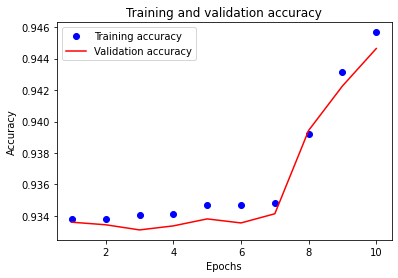

In [ ]:
# epochs = 50
epochs = 10

#Train 데이터를 이용해 모델 학습하기와 함께 test 데이터를 이용해 검증하기
history = model.fit([input_data_train, teacher_data_train], target_data_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs,
                 validation_data=([input_data_test, teacher_data_test], target_data_test))
                 
def plot_training_accuracy(history):

  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  #결과를 matplotlib로 표현하기  
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()
  
plot_training_accuracy(history)

Epoch 10을 기준으로 나타난 표를 보면, epoch 7을 기준으로 Training과 Validation이 동일하게 올라가며 최대 95정확도가 오른 것을 볼 수 있다.  
일반화가 적합하게 되었음을 나타낸다.

### Seq2Seq 모델을 사용한 추론
Prediction에는 train과는 다른 두 가지 모델이 필요합니다.  
Encoder와 Decoder를 분리해야합니다. 그런 다음 Encoder를 통해 전체 input 시퀀스들을 실행한 다음 Decoder로 한 단계식 예측하여 출력을 만듭니다.

In [ ]:
# 이전에 사용한 Encoder모델을 불러옵니다.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder를 위해 새로운 tensor셋을 정의합니다.
# 전에 사용하던 layer들은 사용하지 않습니다.(가중치, bias 모두 포함합니다.).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# 각 단계마다 두 가지 상태 변수를 디코더에 강제로 공급해야합니다.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])
                  
def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w
  
# 주어진 쿼리 (단지 문자열)를 단어 ID로 구성된 벡터로 변환합니다.
# 지정된 언어를 사용하는데, 이것은 입력 (쿼리)에 사용될 수 있습니다.
# Output is 1-D: [timesteps/words]
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

# 주어진 input을 바탕으로, encoder 모델 (infenc_model)과 decoder 모델(infmodel)을 정의합니다.
# 예측된 slot 문장을 반환하도록 작성합니다.
def predict_slots(input_query, infenc_model, infmodel, 
                  len_input=len_input_train, 
                  t2i=t2i_train, s2i=s2i_train, i2s=i2s_train,
                  len_target=len_target_train,
                  attention=False):
    sent_len = len(input_query.split())
    sv = query_to_vector(input_query, len_input, t2i)
    #Encoder 모델에 사용될 수 있도록 reshape처리합니다. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = s2i["O"]
    stop_vec = s2i["O"]
    # 다음 단어를 생성하기 위해 cur_vec를 디코더에 입력으로 지속적으로 공급합니다.
    # "EOS"로 시작하여 cur_vec에 할당됩니다
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "BOS"
    output_query = ""
    # 모델이 "EOS"를 예측하거나 최대 목표 슬롯 길이의 끝에 도달하면 종료하기 전까지 계속 작용합니다.
    while cur_word != "EOS" and i < (len_target-1) and i < sent_len+1:
        i += 1
        if cur_word != "BOS":
            output_query = output_query + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # Attention model을 이용해 적용합니다.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # 모델의 출력은 가능한 모든 단어에 대해 하나의 spot이있는 방대한 softmax 벡터입니다. argmax ()를 사용하여 단어 ID로 변환합니다.
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = i2s[np.argmax(nvec[0,0])]
    return output_query
    
input_query = "what is the cheapest flight from boston to san francisco"
print(predict_slots(input_query, encoder_model, inf_model))

 O O O B-cost_relative B-round_trip I-round_trip O O B-fromloc.city_name O


모델을 돌려보았을 때 cheapest, flight, boston, san franciso와 같은 Slot들을 모두 알아내는 높은 성능을 볼 수 있다.

In [ ]:
import nltk
def evaluate_slot_filling(queries, true_slots,
                          len_input=len_input_test, 
                          t2i=t2i_test, s2i=s2i_test, i2s=i2s_test,
                          len_target=len_target_test):
  predicted_slots = []
  for q in queries:
    s = predict_slots(q, encoder_model, inf_model,
                      len_input, 
                      t2i, s2i, i2s,
                      len_target)
    predicted_slots.append(s)
  # calculate BLEU score
  print('BLEU-1: %f' % nltk.translate.bleu_score.corpus_bleu(true_slots, predicted_slots, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % nltk.translate.bleu_score.corpus_bleu(true_slots, predicted_slots, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % nltk.translate.bleu_score.corpus_bleu(true_slots, predicted_slots, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % nltk.translate.bleu_score.corpus_bleu(true_slots, predicted_slots, weights=(0.25, 0.25, 0.25, 0.25)))
  
evaluate_slot_filling(query_data_test, slot_data_test)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.200123
BLEU-2: 0.447351
BLEU-3: 0.617148
BLEU-4: 0.668843


이제 예측 슬롯 채우기와 실제 슬롯 채우기 사이의 n-gram 수를 비교하여  
번역 품질을 측정하는 데 사용되는 BLEU 알고리즘 (BiLingual Evaluation Understudy)을 사용하여 전체 테스트 데이터 세트에 대해 훈련 된 모델을 평가합니다.  
예측 된 슬롯과 실제 슬롯간에 4-gram 그룹을 각각 비교할 때 전체 모델이 매우 잘 수행되고 있음을 나타냅니다.
